# US Patent Descriptions

This dataset contains the **descriptions of granted US utility patents**, filtered and deduplicated.  
The original data comes from all granted patents in 2025 up to May 20, available from [PatentsView](https://patentsview.org/download/detail_desc_text).

## Splits
- **train**: 10,000 rows for model training  
- **validation**: 2,500 rows for validation  
- **test**: 2,500 rows for evaluation  

## Columns
- **patent_id**: Identifier for the patent; useful for reconciling with other PatentsView datasets  
- **description_text**: Full text of the patent description  
- **description_length**: Character or token length of the description  

## Notes
- The dataset has been deduplicated to remove exact and near-duplicate descriptions.  
- Use this dataset for NLP experiments, such as summarization, classification, or sentence scoring.  

## Usage Example
```python
from datasets import load_dataset

ds = load_dataset("mhurhangeee/us-patent-descriptions")
train_data = ds["train"]
```

## Download from patentsview.

In [1]:
!ls -l
!wget https://s3.amazonaws.com/data.patentsview.org/detail-description-text/g_detail_desc_text_2025.tsv.zip

total 5802252
-rw-rw-r-- 1 jovyan users 4905978183 Apr 18 13:09 g_detail_desc_text_2025.tsv
-rw-r--r-- 1 jovyan users 1035407488 Apr 20 15:05 g_detail_desc_text_2025.tsv.zip
-rw-r--r-- 1 jovyan users       5280 Sep  4 20:48 plan.md
-rw-r--r-- 1 jovyan users      94268 Sep  4 22:24 us-descriptions-corpus.ipynb
--2025-09-04 22:25:57--  https://s3.amazonaws.com/data.patentsview.org/detail-description-text/g_detail_desc_text_2025.tsv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.164.88, 52.217.81.150, 54.231.128.24, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.164.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035407488 (987M) [binary/octet-stream]
Saving to: ‘g_detail_desc_text_2025.tsv.zip.1’

g_detail_desc_text_ 100%[===================>] 987.44M  28.9MB/s    in 35s     

2025-09-04 22:26:33 (28.4 MB/s) - ‘g_detail_desc_text_2025.tsv.zip.1’ saved [1035407488/1035407488]



## Extract

In [2]:
!unzip g_detail_desc_text_2025.tsv.zip

Archive:  g_detail_desc_text_2025.tsv.zip
replace g_detail_desc_text_2025.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Turn to DF

In [20]:
import pandas as pd

file_path = 'g_detail_desc_text_2025.tsv'

df = pd.read_csv(file_path, sep='\t')

print(df)


       patent_id                                   description_text  \
0       12185648  DESCRIPTION OF PREFERRED EMBODIMENT\n\nIt is t...   
1       12185649  DETAILED DESCRIPTION OF THE PREFERRED EMBODIME...   
2       12185650  Repeat use of reference characters in the pres...   
3       12185651  Repeat use of reference characters in the pres...   
4       12185652  DETAILED DESCRIPTION\n\nTerms used herein are ...   
...          ...                                                ...   
76263   12262646  DETAILED DESCRIPTION\n\nReferring toFIGS.1-6,F...   
76264   12262647  DETAILED DESCRIPTION\n\nReferring toFIGS.1-6,F...   
76265   12262648  DETAILED DESCRIPTION\n\nVarious example embodi...   
76266   12262649  DETAILED DESCRIPTION\n\nLike features have bee...   
76267   12262650  DESCRIPTION OF THE EMBODIMENTS\n\nFor ease of ...   

       description_length  
0                    7312  
1                   64014  
2                   35054  
3                   39233  
4      

In [21]:
print(df.shape) 

(76268, 3)


# Length distribution

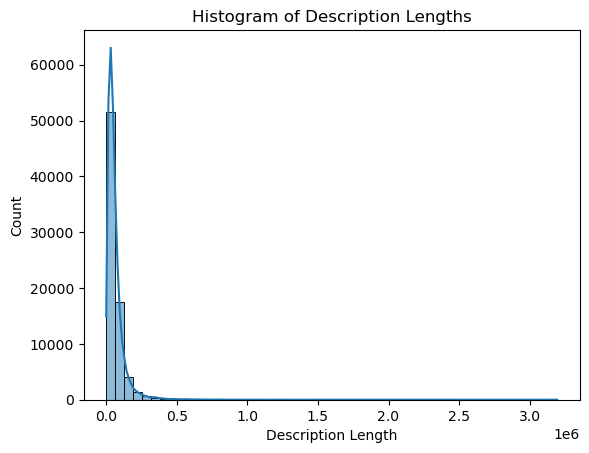

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram
sns.histplot(df['description_length'], bins=50, kde=True)  # kde=True adds a density curve

# Labels and title
plt.xlabel('Description Length')
plt.ylabel('Count')
plt.title('Histogram of Description Lengths')

# Show plot
plt.show()


## Remove some of the tails

(71691, 3)


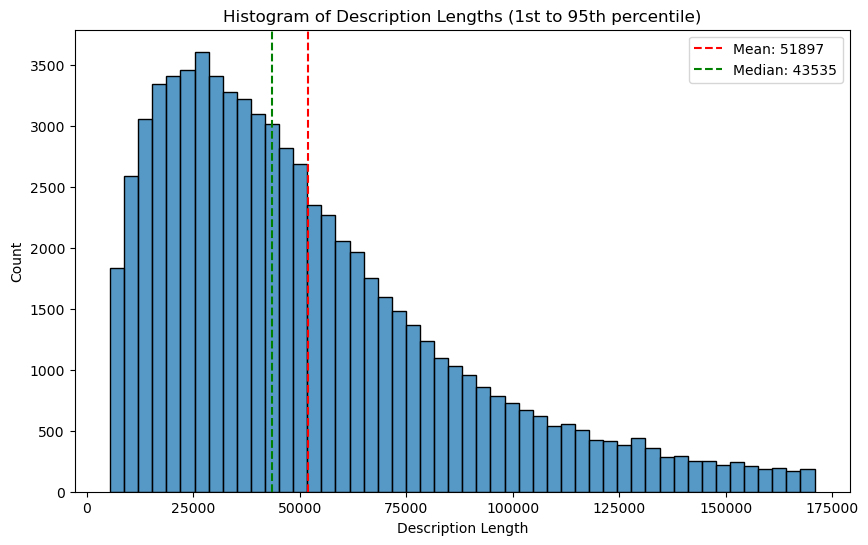

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

upper_limit = df['description_length'].quantile(0.95)
lower_limit = df['description_length'].quantile(0.01)

# Filter dataframe
df = df[(df['description_length'] >= lower_limit) & (df['description_length'] <= upper_limit)]
print(df.shape)

# Compute mean and median
mean_val = df['description_length'].mean()
median_val = df['description_length'].median()

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], bins=50, kde=False)

# Add vertical lines
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.0f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.0f}')

# Labels and title
plt.xlabel('Description Length')
plt.ylabel('Count')
plt.title('Histogram of Description Lengths (1st to 95th percentile)')
plt.legend()
plt.show()

## Remove exact duplicates
Likely continuations. Further dedupe probably needed.

In [24]:
df = df.drop_duplicates(subset='description_text').reset_index(drop=True)
print(len(df))

71538


# Remove near duplicates

In [25]:
!pip install datasketch -q

In [26]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
df = df.iloc[:20000]

In [28]:
from datasketch import MinHash, MinHashLSH

# Parameters
num_perm = 128         # Number of hash functions
threshold = 0.85       # Similarity threshold for duplicates
shingle_size = 5       # Number of words per shingle

# Build LSH index
lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)

# Keep track of representative rows
unique_indices = []

# Precompute MinHashes
minhashes = []

for i, text in enumerate(df['description_text']):
    shingles = set(text.split())  # Or use more sophisticated n-grams
    m = MinHash(num_perm=num_perm)
    for shingle in shingles:
        m.update(shingle.encode('utf8'))
    minhashes.append(m)

# Insert into LSH and filter
for i, m in enumerate(minhashes):
    # Check if any existing item in LSH is similar
    if lsh.query(m):
        continue  # Skip as near-duplicate
    else:
        lsh.insert(f"m{i}", m)
        unique_indices.append(i)

# Create f3_df
df = df.iloc[unique_indices].reset_index(drop=True)

print(f"df shape: {df.shape}")


df shape: (19878, 3)


In [29]:
import gc

del minhashes, unique_indices, lsh
gc.collect()

178924

# Shuffle

In [30]:
train_size = 10000
val_size   = 2500
test_size  = 2500

train_df = df.iloc[:train_size]
val_df   = df.iloc[train_size:train_size + val_size]
test_df  = df.iloc[train_size + val_size:train_size + val_size + test_size]

In [32]:
print(len(train_df), len(val_df), len(test_df))

10000 2500 2500


# Upload to HF

In [33]:
%pip install datasets -q

Note: you may need to restart the kernel to use updated packages.


In [34]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

hf_ds = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

In [35]:
from huggingface_hub import notebook_login

notebook_login()

In [37]:
hf_ds.push_to_hub(
    "mhurhangee/us-patent-descriptions"
)


Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|          |  524kB / 94.8MB            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   8%|7         | 7.34MB / 92.6MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   8%|7         | 3.67MB / 47.3MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   8%|7         | 3.67MB / 46.3MB            

CommitInfo(commit_url='https://huggingface.co/datasets/mhurhangee/us-patent-descriptions/commit/8995be855caea1eaba860c24fb6b89dfcb0a627e', commit_message='Upload dataset', commit_description='', oid='8995be855caea1eaba860c24fb6b89dfcb0a627e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mhurhangee/us-patent-descriptions', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mhurhangee/us-patent-descriptions'), pr_revision=None, pr_num=None)